# Explore Boundaries for Filtered Tiles

We are primarily concerned with removing large chunks of ocean water tiles in the dataset.
<br/>
The goal of this notebook is
- Does the original shape file include the ocean chunks
- Does the natural earch shape files include the ocean chunks
- How much do these two overlap if there is any additional data loss

In [83]:
import os
import tarfile
import rasterio
import numpy as np
import pandas as pd
import geopandas as gd
import matplotlib as mpl
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [ ]:
load_dotenv()

## Load tile and state shape data

In [ ]:
root = os.getenv('DATA_ROOT')

In [ ]:
us_shp = f'{root}/natural_earth_vector/10m_cultural/ne_10m_admin_1_states_provinces.shp'
r1c1_shp = f'{root}/archive/CA/california_R01C01/california_R01C01.shp'
r1c1_tif =  f'{root}/archive/CA/california_R01C01/california_R01C01.tif'
r1c1_tar = f'{root}/chunks/california_R01C01.tar'


Load the CA state data

In [3]:
us = gd.read_file(us_shp)
ca = us[us.name.eq('California')]

In [85]:
r1c1_tile = gd.read_file(r1c1_shp)

Extract the master shape file for the filtered tile

**[Deprecated]** the chunks are now written straight to webdataset dataset tar files not by chunk

In [ ]:
with tarfile.open(r1c1_tar, mode='r:gz') as tf:
    shapes = [name for name in tf.getnames() if name.endswith('.json')]

    shps = []
    for shape in shapes:
        loader = tf.extractfile(shape)
        shp = gd.read_file(loader)
        shps.append(shp)

In [5]:
tile_01_shp = gd.GeoDataFrame(pd.concat(shps, ignore_index=True), crs=ca.crs)

In [6]:
tile_01_shp.shape

(21668, 9)

In [7]:
tile_01_shp.head()

,id,Link,Date,Photo_ID,state,tile_id,block_x,block_y,geometry
0,0,https://earthexplorer.usgs.gov/scene/metadata/...,1952-09-01,1QD0000050030,california,R01C01,19,128,"POLYGON ((-124.21214 41.99516, -124.21214 41.9..."
1,0,https://earthexplorer.usgs.gov/scene/metadata/...,1952-09-01,1QD0000050030,california,R01C01,19,129,"POLYGON ((-124.20984 41.99516, -124.20984 41.9..."
2,0,https://earthexplorer.usgs.gov/scene/metadata/...,1952-09-01,1QD0000050030,california,R01C01,19,130,"POLYGON ((-124.20754 41.99516, -124.20754 41.9..."
3,0,https://earthexplorer.usgs.gov/scene/metadata/...,1952-09-01,1QD0000050030,california,R01C01,19,131,"POLYGON ((-124.20524 41.99516, -124.20524 41.9..."
4,0,https://earthexplorer.usgs.gov/scene/metadata/...,1952-09-01,1QD0000050009,california,R01C01,19,132,"MULTIPOLYGON (((-124.20102 41.99518, -124.2013..."


In [8]:
del shps

## Display Filtered Tile

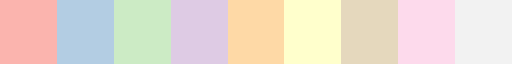

In [9]:
mpl.colormaps['Pastel1']

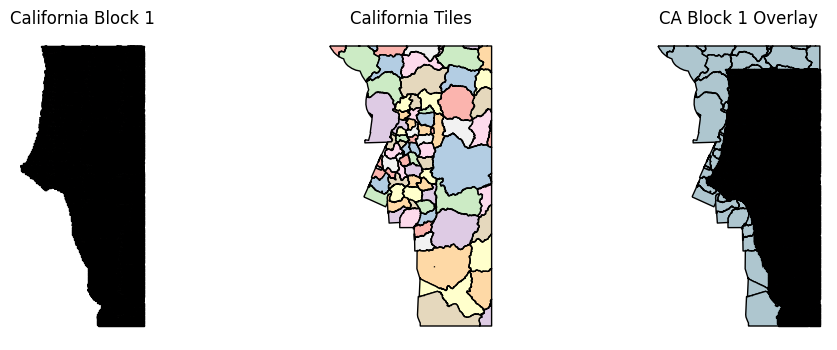

In [11]:
#cmap = sns.color_palette(palette='Pastel1', as_cmap=True)
cmap = mpl.colormaps['Pastel1']
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

tile_01_shp.plot(ax=axs[0], cmap=cmap, edgecolor='black')
axs[0].set_title('California Block 1')
axs[0].axis('off')

r1c1_tile.plot(ax=axs[1], cmap=cmap, edgecolor='black')
axs[1].set_title('California Tiles')
axs[1].axis('off')

r1c1_tile.plot(ax=axs[2], color='#AEC6CF', edgecolor='black')
tile_01_shp.plot(ax=axs[2], edgecolor='black')
axs[2].set_title('CA Block 1 Overlay')
axs[2].axis('off')

plt.show()

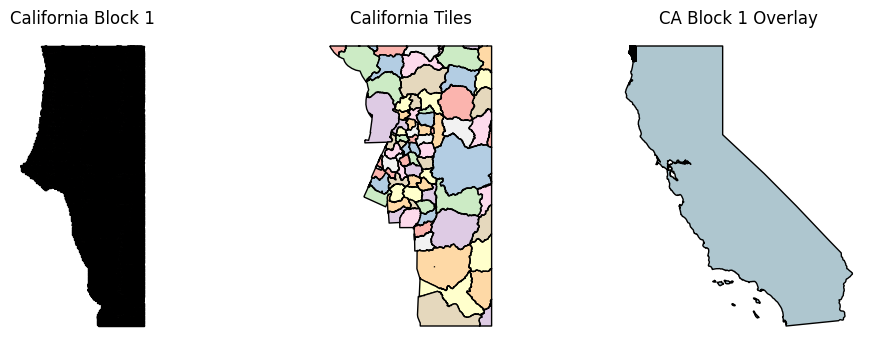

In [10]:
#cmap = sns.color_palette(palette='Pastel1', as_cmap=True)
cmap = mpl.colormaps['Pastel1']
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

tile_01_shp.plot(ax=axs[0], cmap=cmap, edgecolor='black')
axs[0].set_title('California Block 1')
axs[0].axis('off')

r1c1_tile.plot(ax=axs[1], cmap=cmap, edgecolor='black')
axs[1].set_title('California Tiles')
axs[1].axis('off')

ca.plot(ax=axs[2], color='#AEC6CF', edgecolor='black')
tile_01_shp.plot(ax=axs[2], edgecolor='black')
axs[2].set_title('CA Block 1 Overlay')
axs[2].axis('off')

plt.show()

In [12]:
del tile_01_shp

## Examine Tile Borders V.S. Natural Earth Borders

In [89]:
tif = rasterio.open(r1c1_tif) # This needs to be closed at the end

Grab all the chunk windows

In [ ]:
blocks = tif.block_windows(1)
windows = [window for _, window in blocks]

Take a subset that falls into the tile boundaries but not natural earth (until the end)

In [79]:
window_sub = windows[97:107]
imgs = []

for w_sub in window_sub:
    imgs.append(tif.read(window=w_sub))

imgs = np.concat(imgs)

A water strip until land is reached, meaning the original tile shapes include all the water sections as within the boundaries, which we do not want

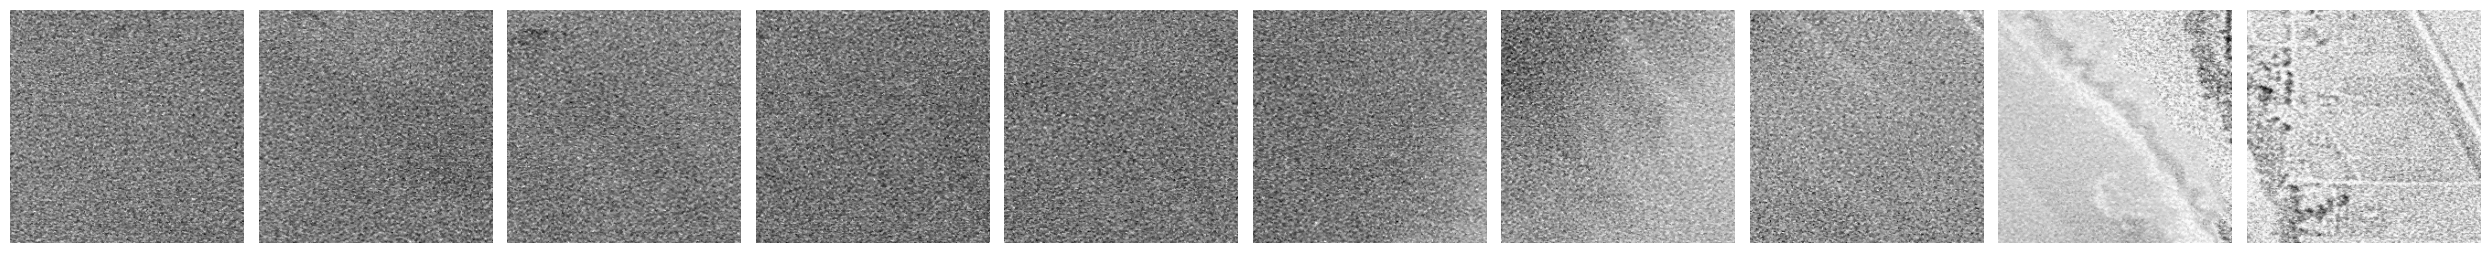

In [82]:
fig, axs = plt.subplots(1, 10, figsize=(25, 5))
for i, img in enumerate(imgs):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [15]:
tif.close()